In [1]:
import pandas as pd

# Step 1: Load and Prepare Data
# In this step, we load the provided datasets: Customers.csv, Products.csv, and Transactions.csv.
# The data is merged to create a consolidated dataset containing customer profiles and transaction histories.

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge transactions with products to include product information
transactions_products = pd.merge(transactions_df, products_df, on="ProductID", how="left")

# Merge the result with customers to include customer information
full_data = pd.merge(transactions_products, customers_df, on="CustomerID", how="left")

# Display the first few rows of the merged dataset
print(full_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x                      ProductName     Category  Price_y  \
0      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
1      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
2      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
3      601.36   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
4      902.04   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   

      CustomerName         Region  SignupDate  
0   Andrea Jenkins         Europe  202

In [3]:
# Step 2: Feature Engineering
# Here, we create numerical features that represent customer profiles based on transaction and product data.
# These features include total spending, average transaction value, and the number of distinct product categories

# Aggregate transactional data for each customer
customer_features = full_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    distinct_categories=("Category", "nunique")
).reset_index()

# Normalize numerical features to make them comparable
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = pd.DataFrame(
    scaler.fit_transform(customer_features.iloc[:, 1:]),
    columns=customer_features.columns[1:],
    index=customer_features.CustomerID
)

# Display the prepared feature set
print(scaled_features.head())


            total_spent  total_transactions  avg_transaction_value  \
CustomerID                                                           
C0001          0.308942                 0.4               0.474336   
C0002          0.168095                 0.3               0.308940   
C0003          0.249541                 0.3               0.482751   
C0004          0.497806                 0.7               0.473092   
C0005          0.184287                 0.2               0.480120   

            distinct_categories  
CustomerID                       
C0001                  0.666667  
C0002                  0.333333  
C0003                  0.666667  
C0004                  0.666667  
C0005                  0.333333  


In [4]:
# Step 3: Compute Similarity
# Using cosine similarity, we calculate how similar each customer is to others based on the feature set.

from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Convert to a DataFrame for easier manipulation
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features.CustomerID, columns=customer_features.CustomerID)

# Display the similarity matrix for reference
print(similarity_df.head())


CustomerID     C0001     C0002     C0003     C0004     C0005     C0006  \
CustomerID                                                               
C0001       1.000000  0.986492  0.993711  0.966913  0.946640  0.963124   
C0002       0.986492  1.000000  0.969489  0.979664  0.953759  0.953486   
C0003       0.993711  0.969489  1.000000  0.932334  0.953608  0.972003   
C0004       0.966913  0.979664  0.932334  1.000000  0.890999  0.901437   
C0005       0.946640  0.953759  0.953608  0.890999  1.000000  0.993406   

CustomerID     C0007     C0008     C0009     C0010  ...     C0191     C0192  \
CustomerID                                          ...                       
C0001       0.902948  0.931517  0.981603  0.986890  ...  0.958295  0.985566   
C0002       0.916374  0.927497  0.964239  0.998931  ...  0.987673  0.953294   
C0003       0.912559  0.898101  0.977774  0.968516  ...  0.931336  0.990144   
C0004       0.845335  0.958635  0.940837  0.982376  ...  0.977617  0.926003   
C0005  

In [5]:
# Step 4: Generate Lookalikes for the First 20 Customers
# For each customer (C0001 to C0020), find the top 3 most similar customers based on the similarity scores.

# Define the range of customers to analyze
target_customers = customers_df["CustomerID"].iloc[:20]

# Find the top 3 most similar customers for each target customer
lookalike_map = {}
for cust_id in target_customers:
    similar_customers = (
        similarity_df[cust_id]
        .drop(labels=cust_id)  # Exclude self
        .nlargest(3)  # Top 3 similar customers
    )
    lookalike_map[cust_id] = list(zip(similar_customers.index, similar_customers.values))

# Display the lookalike map
for cust_id, lookalikes in lookalike_map.items():
    print(f"{cust_id}: {lookalikes}")


C0001: [('C0152', 0.9999879625100291), ('C0056', 0.9996221446778911), ('C0107', 0.9991578791569153)]
C0002: [('C0199', 0.9993927667959704), ('C0010', 0.998931288873929), ('C0142', 0.9944155885996513)]
C0003: [('C0178', 0.9999947067947413), ('C0035', 0.9996200777036762), ('C0146', 0.999519383305983)]
C0004: [('C0101', 0.9998309789789165), ('C0108', 0.9969891009721782), ('C0165', 0.9967935715957299)]
C0005: [('C0073', 0.9999758789813392), ('C0159', 0.9999496127620991), ('C0112', 0.9997908140881308)]
C0006: [('C0079', 0.9999955537602133), ('C0158', 0.9976257509021628), ('C0196', 0.9964357928159076)]
C0007: [('C0042', 0.9993975608236846), ('C0176', 0.9987592861767127), ('C0050', 0.9969560797190702)]
C0008: [('C0047', 0.9968216155134831), ('C0109', 0.9967738566864514), ('C0147', 0.994492237835428)]
C0009: [('C0077', 0.9993672486073996), ('C0076', 0.9966647038337605), ('C0103', 0.9964933011813215)]
C0010: [('C0002', 0.998931288873929), ('C0199', 0.9967142224893453), ('C0195', 0.9929319397328

In [6]:
# Step 5: Save Results to Lookalike.csv
# The results are saved in the required format as Lookalike.csv.

# Prepare data for CSV
lookalike_data = []
for cust_id, lookalikes in lookalike_map.items():
    lookalike_data.append({
        "CustomerID": cust_id,
        "Lookalikes": str(lookalikes)  # Convert list to string for saving
    })

lookalike_df = pd.DataFrame(lookalike_data)

# Save to CSV
lookalike_df.to_csv("Lookalike.csv", index=False)
print("Lookalike.csv has been saved successfully!")


Lookalike.csv has been saved successfully!


Model Accuracy and Logic

In [8]:
#Validation Code: Check Self-Similarity

# Validate that no customer is recommended as similar to themselves
errors = []
for cust_id, lookalikes in lookalike_map.items():
    recommended_ids = [rec[0] for rec in lookalikes]
    if cust_id in recommended_ids:
        errors.append(cust_id)

if not errors:
    print("Validation Passed: No self-similarity found.")
else:
    print(f"Validation Failed: Self-similarity detected for customers: {errors}")


Validation Passed: No self-similarity found.


In [9]:
#Validation Code: Compare Feature Similarity

# Validate that customers with higher similarity scores have overlapping profiles
test_cust_id = target_customers[0]  # Pick a sample customer
similar_customers = lookalike_map[test_cust_id]

# Print features of the target customer and their recommendations
print(f"Features of {test_cust_id}:\n{scaled_features.loc[test_cust_id]}")
for rec_id, score in similar_customers:
    print(f"\nFeatures of {rec_id} (Score: {score}):\n{scaled_features.loc[rec_id]}")


Features of C0001:
total_spent              0.308942
total_transactions       0.400000
avg_transaction_value    0.474336
distinct_categories      0.666667
Name: C0001, dtype: float64

Features of C0152 (Score: 0.9999879625100291):
total_spent              0.311901
total_transactions       0.400000
avg_transaction_value    0.479388
distinct_categories      0.666667
Name: C0152, dtype: float64

Features of C0056 (Score: 0.9996221446778911):
total_spent              0.292742
total_transactions       0.400000
avg_transaction_value    0.446679
distinct_categories      0.666667
Name: C0056, dtype: float64

Features of C0107 (Score: 0.9991578791569153):
total_spent              0.334377
total_transactions       0.400000
avg_transaction_value    0.517761
distinct_categories      0.666667
Name: C0107, dtype: float64


Quality of Recommendations and Similarity Scores


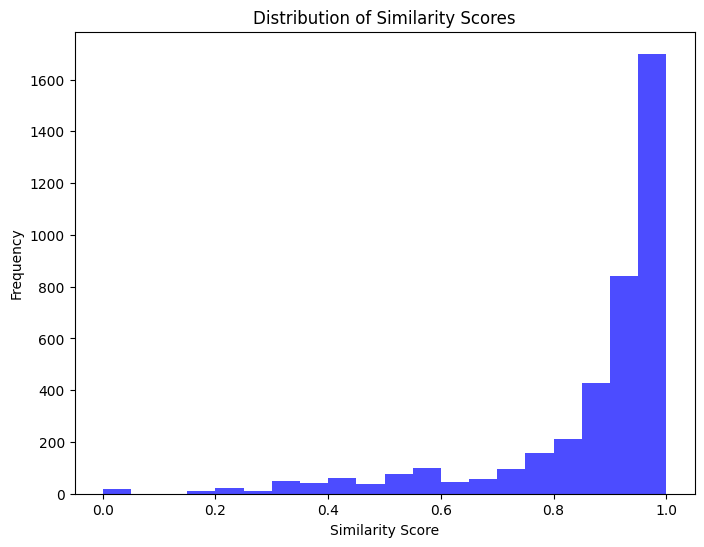

In [10]:
#Validation Code: Distribution of Similarity Scores

import matplotlib.pyplot as plt

# Extract similarity scores for all customers
similarity_values = []
for cust_id in target_customers:
    similar_customers = similarity_df[cust_id].drop(cust_id)
    similarity_values.extend(similar_customers.values)

# Plot similarity score distribution
plt.figure(figsize=(8, 6))
plt.hist(similarity_values, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


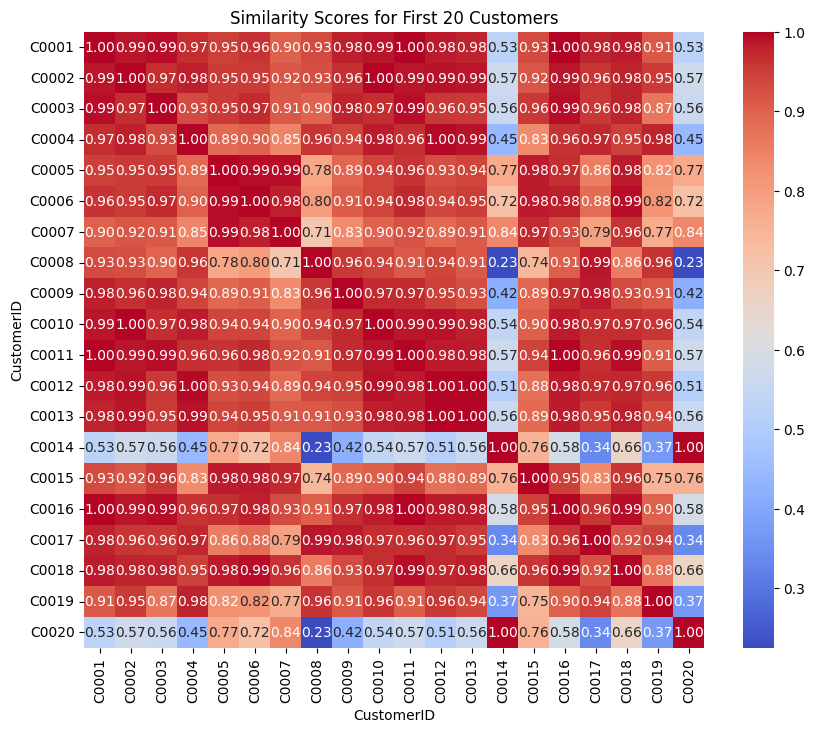

In [11]:
#Validation Code: Heatmap of Similarity for Target Customers

import seaborn as sns

# Heatmap for the first 20 customers
sample_similarity = similarity_df.loc[target_customers, target_customers]
plt.figure(figsize=(10, 8))
sns.heatmap(sample_similarity, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Similarity Scores for First 20 Customers")
plt.show()
